In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)
from sklearn.model_selection import train_test_split

Using PyTorch version: 1.8.1+cu101  Device: cpu


In [22]:
train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True,
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('./data', 
                                    train=False,
                                    download=True,
                                    transform=transforms.ToTensor())

In [23]:
X, y = train_dataset.data.numpy(), train_dataset.targets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

trainx: torch.Size([28, 28]) type: torch.ByteTensor
target_y: torch.Size([]) type: torch.LongTensor


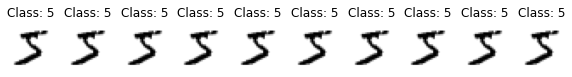

In [19]:
for (trainx, target_y) in zip(train_dataset.data, train_dataset.targets):
    print('trainx:', trainx.size(), 'type:', trainx.type())
    print('target_y:', target_y.size(), 'type:', target_y.type())
    break
################################################################################
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(trainx.numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(target_y.item()))

### 1 (a) Developing Model with Dropout=0.2

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 50)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        x = self.fc3(x)
        # if self.training:
            # return F.log_softmax(self.fc3(x), dim=1)
        # else:
        return x
model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)


In [ ]:
hidden_sizes=[]
class Net(nn.Module):
    def __init__(self,hidden_sizes):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(28*28, hidden_sizes[0])
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_sizes[0],hidden_sizes[1])
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc3_drop = nn.Dropout(0.2)
        self.fc4 = nn.Linear(hidden_sizes[2],10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.logsigmoid(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.logsigmoid(self.fc2(x))
        x = self.fc2_drop(x)
        x = F.logsigmoid(self.fc3(x))
        x = self.fc3_drop(x)
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)

In [6]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

In [ ]:
neurons =[]
accuracy_value=[]
loss_value = []

for i in range(2,101):
  model = Net([i,50,100]).to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
  criterion = nn.CrossEntropyLoss()
    
  def train(epoch, log_interval=200):

    model.train()
    
    # Training set batches are looped over
    for batch_idx, (data, target) in enumerate(train_loader):
        # Data from GPU copied
        data = data
        target = target
        # Buffers of zero gradient
        optimizer.zero_grad()
        # Network is used to pass data
        output = model(data)
        # Loss Calculation
        loss = criterion(output, target)
        # Back Propagation
        loss.backward()
        # Weights Updated
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
            

  def evaulate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data
        target = target
        output = model(data)
        output = F.log_softmax(output, dim=1)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    accuracy
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))    
    
###########################################################################################

#%%time
  epochs = 10

  lossv, accv = [], []


  for epoch in range(1, epochs + 1):
    train(epoch)
    evaulate(lossv, accv)
  
  neurons.append(i)
  accuracy_value.append(accv[9].item())

Streaming output truncated to the last 5000 lines.
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.563629
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.287707
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.354727
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.378869
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.353379

Validation set: Average loss: 0.3080, Accuracy: 9076/10000 (91%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.317223
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.353108
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.281495
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.300867
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.342376
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.442837
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.260469
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.394971
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.416396
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.310533

Validation set: Average loss: 0.2755, Accuracy: 9168/10000 (92%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.141318
Train Epoch: 8 [6400/60000

### 1(b) Plot of Accuracy vs Neurons for 1st hidden layer with dropouts

Text(0.5, 1.0, 'Neuron vs Accuracy')

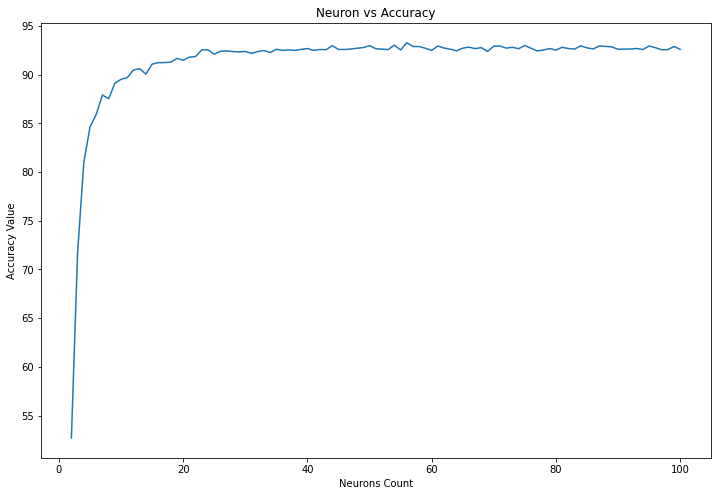

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(neurons,accuracy_value)
plt.xlabel("Neurons Count")
plt.ylabel("Accuracy Value")
plt.title("Neuron vs Accuracy")

In [ ]:
def evaulate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data
        target = target
        output = model(data)
        output = F.log_softmax(output, dim=1)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))
		
		
###########################################################################################

#%%time
epochs = 2

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    evaulate(lossv, accv)

### 2(a) Model for 1st hidden layer without dropouts

In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

In [8]:
hidden_sizes=[]
class Net(nn.Module):
    def __init__(self,hidden_sizes):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(28*28, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0],hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2],10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.logsigmoid(self.fc1(x))
        x = F.logsigmoid(self.fc2(x))
        x = F.logsigmoid(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)

In [28]:
neurons =[]
accuracy_value=[]
loss_value = []


for i in range(100,101):
  model = Net([i,50,100]).to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
  criterion = nn.CrossEntropyLoss()
  #print(model)
  
  
  def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data
        target = target
        # Zero gradient buffers
        optimizer.zero_grad()
        # Pass data through the network
        output = model(data)
        # Calculate loss
        loss = criterion(output, target)
        # Backpropagate
        loss.backward()
        # Update weights
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
            

  def evaulate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data
        target = target
        output = model(data)
        output = F.log_softmax(output, dim=1)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] 
        # get the index of the max log-probability
        correct += pred.eq(target.data).sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    accuracy
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))
    #print(accuracy.item())
    
    
###########################################################################################

#%%time
  epochs = 10

  lossv, accv = [], []

  for epoch in range(1, epochs + 1):
    train(epoch)
    evaulate(lossv, accv)
  
  neurons.append(i)
  accuracy_value.append(accv[9].item())

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.409170
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.343006
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.266843
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.268463
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.372505
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.323530
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.261941
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.249767
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.969035
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.560930

Validation set: Average loss: 1.3733, Accuracy: 5080/10000 (51%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.548653
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.324855
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.278548
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.227170
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.236240
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.197960
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.054040
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.087361
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.16

### 2(b) Plot of Accuracy vs neuron for 1st hidden layer without dropouts

Text(0.5, 1.0, 'Neuron vs Accuracy')

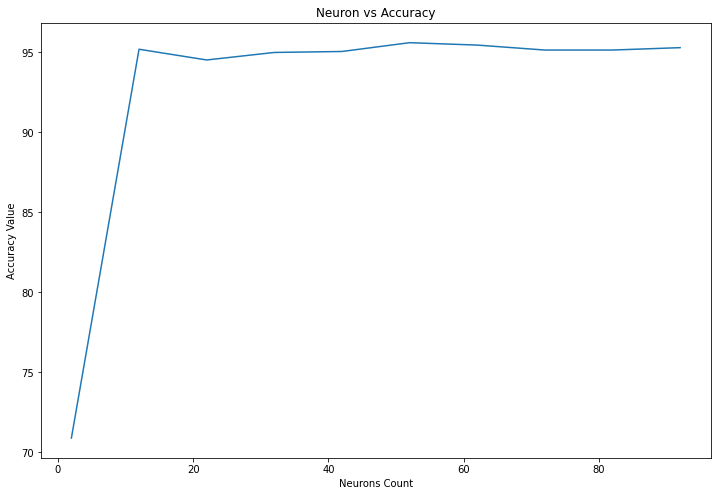

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(neurons,accuracy_value)
plt.xlabel("Neurons Count")
plt.ylabel("Accuracy Value")
plt.title("Neuron vs Accuracy")

In [29]:
def evaulate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data
        target = target
        output = model(data)
        output = F.log_softmax(output, dim=1)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))
		
		
###########################################################################################

#%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    evaulate(lossv, accv)
    #hidden_features


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.412159
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.526094
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.223067
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.149455
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.486228
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.183974
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.141113
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.768586
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.251622
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.205079

Validation set: Average loss: 0.2209, Accuracy: 9307/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.277476
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.379091
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.207194
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.847627
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.163237
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.343623
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.496191
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.183224
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.31

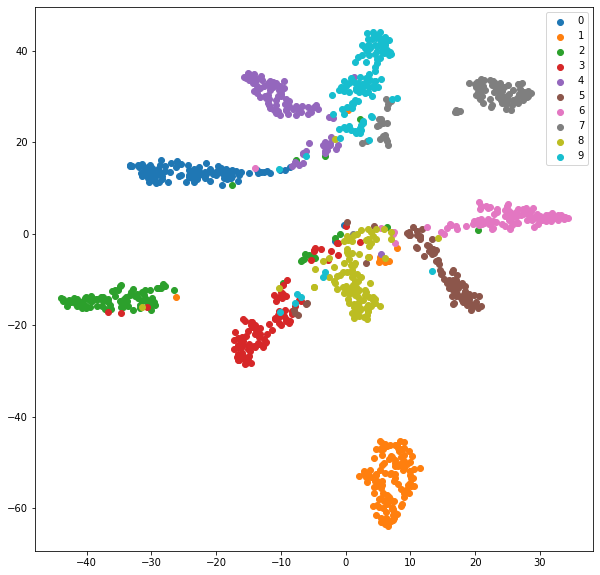

In [27]:
from sklearn.manifold import TSNE
model.eval()
vis_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=1000, 
                                            shuffle=True)

targets = None
for data, t in vis_loader:
    hidden_features = model(data)
    targets = t
    break
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(hidden_features.detach().numpy())
colors_map = targets
np.where(colors_map==6)
colors = np.array([x for x in 'b-g-r-c-m-y-k-purple-coral-lime'.split('-')])
colors_map = colors_map[:1000]
plt.figure(figsize=(10,10))
for cl in range(10):
    indices = np.where(colors_map==cl)
    plt.scatter(X_tsne[indices,0], X_tsne[indices, 1], label=cl)
plt.legend()
plt.show()

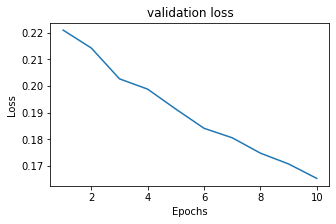

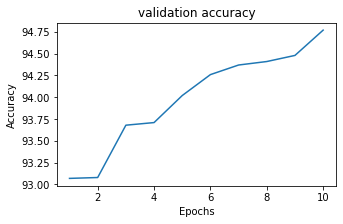

In [30]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy");

3(a) Model for Last hidden layer without dropouts

In [1]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

NameError: ignored

In [ ]:
hidden_sizes=[100, 50, 100]
class Net(nn.Module):
    def __init__(self,hidden_sizes):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(28*28, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0],hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2],10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.logsigmoid(self.fc1(x))
        x = F.logsigmoid(self.fc2(x))
        x = F.logsigmoid(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)

In [9]:
neurons =[]
accuracy_value=[]
loss_value = []

for i in range(2,101,10):
  model = Net([100,50,i]).to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
  criterion = nn.CrossEntropyLoss()
  #print(model)
  
  def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data
        target = target
        # Zero gradient buffers
        optimizer.zero_grad()
        # Pass data through the network
        output = model(data)
        # Calculate loss
        loss = criterion(output, target)
        # Backpropagate
        loss.backward()
        # Update weights
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
            

  def evaulate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data
        target = target
        output = model(data)
        output = F.log_softmax(output, dim=1)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    accuracy
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))
    #print(accuracy.item())
    
    
###########################################################################################

#%%time
  epochs = 10

  lossv, accv = [], []


  for epoch in range(1, epochs + 1):
    train(epoch)
    evaulate(lossv, accv)
  
  neurons.append(i)
  accuracy_value.append(accv[9].item())

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.395189
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.358230
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.360997
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.331533
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.286606
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.320405
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.301443
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.297198
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.311418
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.303866

Validation set: Average loss: 2.2974, Accuracy: 1135/10000 (11%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.298865
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.291920
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.302158
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.285556
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.274413
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.189464
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.988817
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.937608
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.02

3(b) Plot of Accuracy vs neuron for Last hidden layer without dropouts

Text(0.5, 1.0, 'Neuron vs Accuracy')

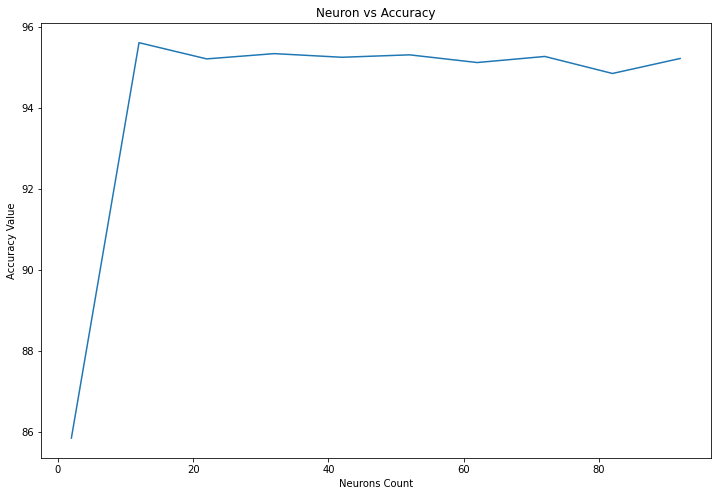

In [10]:
fig = plt.figure(figsize=(12,8))
plt.plot(neurons,accuracy_value)
plt.xlabel("Neurons Count")
plt.ylabel("Accuracy Value")
plt.title("Neuron vs Accuracy")

4(a) Model for Last hidden layer with dropouts=0.2

In [11]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

In [12]:
hidden_sizes=[]
class Net(nn.Module):
    def __init__(self,hidden_sizes):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(28*28, hidden_sizes[0])
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_sizes[0],hidden_sizes[1])
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc3_drop = nn.Dropout(0.2)
        self.fc4 = nn.Linear(hidden_sizes[2],10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.logsigmoid(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.logsigmoid(self.fc2(x))
        x = self.fc2_drop(x)
        x = F.logsigmoid(self.fc3(x))
        x = self.fc3_drop(x)
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)

In [13]:
neurons =[]
accuracy_value=[]
loss_value = []

for i in range(2,101,10):
  model = Net([100,50,i]).to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
  criterion = nn.CrossEntropyLoss()
    
  def train(epoch, log_interval=200):

    model.train()
    
    # Training set batches are looped over
    for batch_idx, (data, target) in enumerate(train_loader):
        # Data from GPU copied
        data = data
        target = target
        # Buffers of zero gradient
        optimizer.zero_grad()
        # Network is used to pass data
        output = model(data)
        # Loss Calculation
        loss = criterion(output, target)
        # Back Propagation
        loss.backward()
        # Weights Updated
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
            

  def evaulate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data
        target = target
        output = model(data)
        output = F.log_softmax(output, dim=1)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    accuracy
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))    
    
###########################################################################################

#%%time
  epochs = 10

  lossv, accv = [], []


  for epoch in range(1, epochs + 1):
    train(epoch)
    evaulate(lossv, accv)
  
  neurons.append(i)
  accuracy_value.append(accv[9].item())

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.496604
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.322130
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.346289
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.288853
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.296629
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.334832
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.281650
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.325101
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.314375
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.278663

Validation set: Average loss: 2.2976, Accuracy: 1135/10000 (11%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.309503
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.279462
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.284398
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.277940
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.285502
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.286364
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.289827
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.291332
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.29

4(b) Plot of Accuracy vs neuron for Last hidden layer with dropouts=0.2

Text(0.5, 1.0, 'Neuron vs Accuracy')

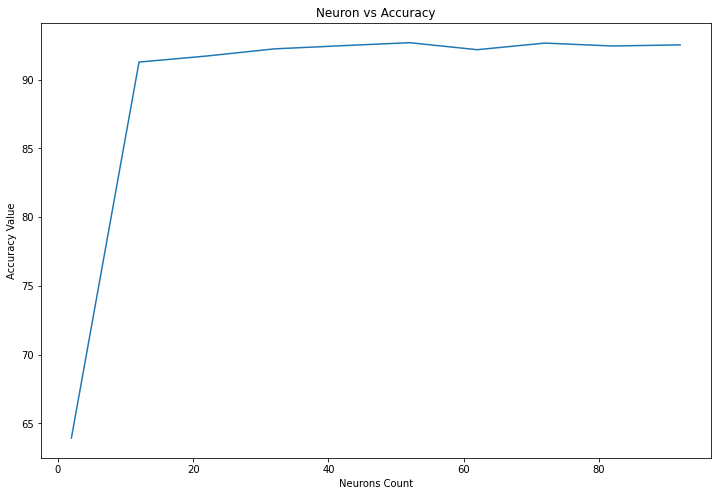

In [14]:
fig = plt.figure(figsize=(12,8))
plt.plot(neurons,accuracy_value)
plt.xlabel("Neurons Count")
plt.ylabel("Accuracy Value")
plt.title("Neuron vs Accuracy")